In [1]:
%cd ../

/home/gramos/Projects/MIIA-A23/code/mercury-duckling


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import ball, disk

import torch
from torchvision import tv_tensors
from torchvision.datasets import CocoDetection
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.datasets import wrap_dataset_for_transforms_v2
from mercury_duckling.datasets.transforms import (
    Blobify,
    OneHotEncodeFromBlobs,
    ResizeLongestSideAndPad,
    Colormap,
    Clahe, 
    MinMaxNormalization,
)
from mercury_duckling.datasets import ThermalDataset

/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/gramos/.pyenv/versions/3.11.5/envs/thermal/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
transform = None
target_transform = None
transforms = v2.Compose(
    [
        v2.ToImage(),
        ResizeLongestSideAndPad(target_size=(256, 320)),
        Blobify(),
        OneHotEncodeFromBlobs(),
        v2.ToDtype({tv_tensors.Image: torch.float32, "others": None}, scale=False),
    ]
)
root="../../data/merged_dataset_delam_thm"
dataset = ThermalDataset(
    root=root,
    annFile=os.path.join(root, "annotations/delamination.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset = wrap_dataset_for_transforms_v2(
    dataset,
    target_keys=["masks", "labels", "boxes", "image_id"]
)
root="../../data/merged_dataset_concrete"
dataset_concrete = CocoDetection(
    root=root,
    annFile=os.path.join(root, "annotations/concrete.json"),
    transform=transform,
    target_transform=target_transform,
    transforms=transforms,
)
dataset_concrete = wrap_dataset_for_transforms_v2(
    dataset_concrete,
    target_keys=["masks", "labels", "boxes", "image_id"]
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [8]:
idx = 305
input, target = dataset[idx]
print("Image ID:", target["image_id"])
print(
    "input shape:", input.shape, 
    "\ninput class:", type(input),
    "\ninput dtype:", input.dtype
)
print(
    "\ntarget shape:", target["masks"].shape,
    "\nnumber of targets:", len(target["boxes"]),
    "\ntarget class:", type(target["masks"]),
    "\ntarget dtype:", target["masks"].dtype
)

Image ID: 306
input shape: torch.Size([1, 256, 320]) 
input class: <class 'torchvision.tv_tensors._image.Image'> 
input dtype: torch.float32

target shape: torch.Size([6, 256, 320]) 
number of targets: 6 
target class: <class 'torchvision.tv_tensors._mask.Mask'> 
target dtype: torch.uint8


In [9]:
def get_visible(file_name, vis_dataset):
    vis_name = file_name.replace("IR", "VIS")
    for _, img_info in vis_dataset.coco.imgs.items():
        if img_info["file_name"] == vis_name:
            return img_info["id"]

file_name = dataset.coco.imgs[idx + 1]["file_name"]
print(file_name)
vis_input, vis_target = dataset_concrete[get_visible(file_name, dataset_concrete) - 1]

IR04_35.jpg


In [115]:
normalization = MinMaxNormalization()
clahe_transform = Clahe()
cmap_transform = Colormap(colormap="inferno")

input *= torch.tensor(vis_target["masks"].sum(dim=0).bool())
input = tv_tensors.Image(input)

input_clahe = normalization(input)
input_clahe = clahe_transform(input_clahe)
input_clahe = cmap_transform(input_clahe)

input  = cmap_transform(input)

/tmp/ipykernel_63851/930511808.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input *= torch.tensor(vis_target["masks"].sum(dim=0).bool())


In [151]:
pil_input = to_pil_image(input)
entropy_img = entropy(np.array(pil_input.convert("L"), dtype=np.uint8), disk(16))

Text(0.5, 1.0, 'Entropy image')

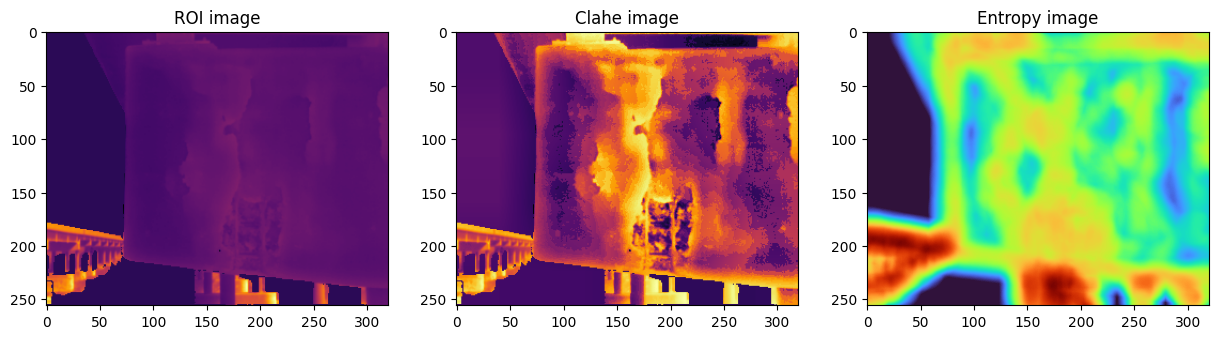

In [153]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

img0 = ax0.imshow(to_pil_image(input), cmap=None)
ax0.set_title("ROI image")
ax1.imshow(to_pil_image(input_clahe), cmap=None)
ax1.set_title("Clahe image")
ax2.imshow(entropy_img / entropy_img.max(), cmap='turbo')
ax2.set_title("Entropy image")